In [1]:

import numpy as np
import torch
from core.datasetclass import HydrogelDataset

In [2]:
dataset = HydrogelDataset(data_dir = "/mnt/c/Users/narun/Desktop/Project/hydrogel/gnn/dataset/uniaxial_signal_/")

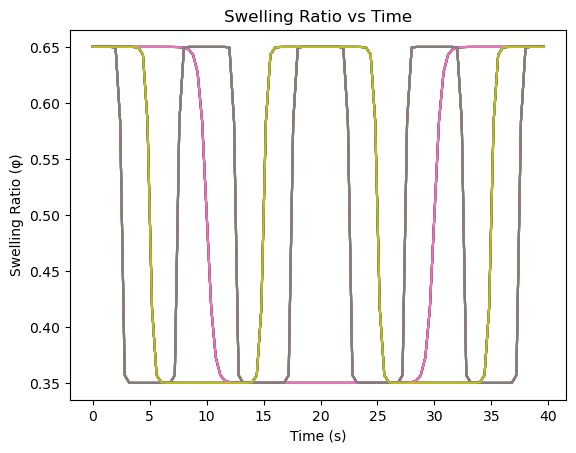

In [3]:
import matplotlib.pyplot as plt
for i in range(len(dataset)):
    sample = dataset[i]
    plt.plot(sample['time'], np.max(sample['swelling_phi'].detach().numpy(), axis = 1), label=f'Sample {dataset.get_name(i)}')
    # plt.plot(sample['time'], sample['x'][:, ])
    plt.xlabel('Time (s)')
    plt.ylabel('Swelling Ratio (φ)')
    plt.title('Swelling Ratio vs Time')
# plt.legend()
plt.show()

In [4]:
#plot phi field and displacement as deformed domain
import matplotlib.pyplot as plt
import numpy as np
idx = 12
sample = dataset[idx]
mesh_pos = sample.mesh_pos.numpy()
cells = sample.cells.numpy()
phi = sample.phi.numpy()
u = sample.world_pos.numpy() - mesh_pos
deformed_pos = mesh_pos + u

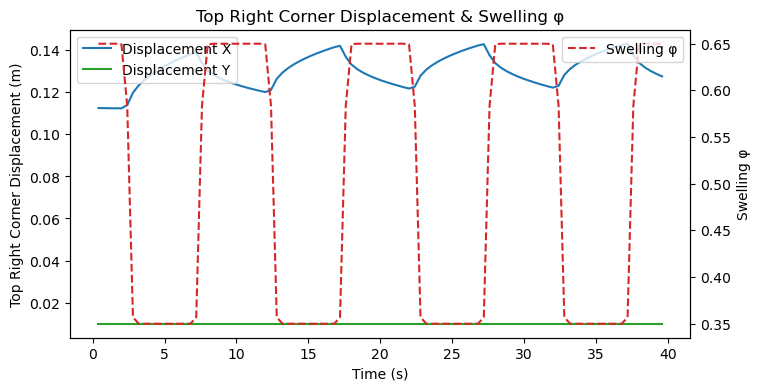

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Extract top-right corner displacement
timestart = 1  # Corresponds to time = 2.5s
mask = (mesh_pos[:, 0] == np.max(mesh_pos[:, 0])) & (mesh_pos[:, 1] == np.max(mesh_pos[:, 1]))
top_right_corner_u = deformed_pos[timestart:, mask, :]  # shape: (nt, 1, 2)
top_right_corner_u = top_right_corner_u.squeeze(axis=1)  # (nt, 2)

# Plot
fig, ax1 = plt.subplots(figsize=(8,4))

# Left y-axis: displacement
ax1.plot(sample["time"][timestart:], top_right_corner_u[:, 0], label="Displacement X", color="tab:blue")
ax1.plot(sample["time"][timestart:], top_right_corner_u[:, 1], label="Displacement Y", color="tab:green")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Top Right Corner Displacement (m)")
ax1.legend(loc="upper left")

# Right y-axis: swelling phi
ax2 = ax1.twinx()
ax2.plot(sample["time"][timestart:], np.max(sample['swelling_phi'].detach().numpy(), axis = 1)[timestart:], label="Swelling φ", color="tab:red", linestyle="--")
ax2.set_ylabel("Swelling φ")
ax2.legend(loc="upper right")

plt.title("Top Right Corner Displacement & Swelling φ")
plt.show()


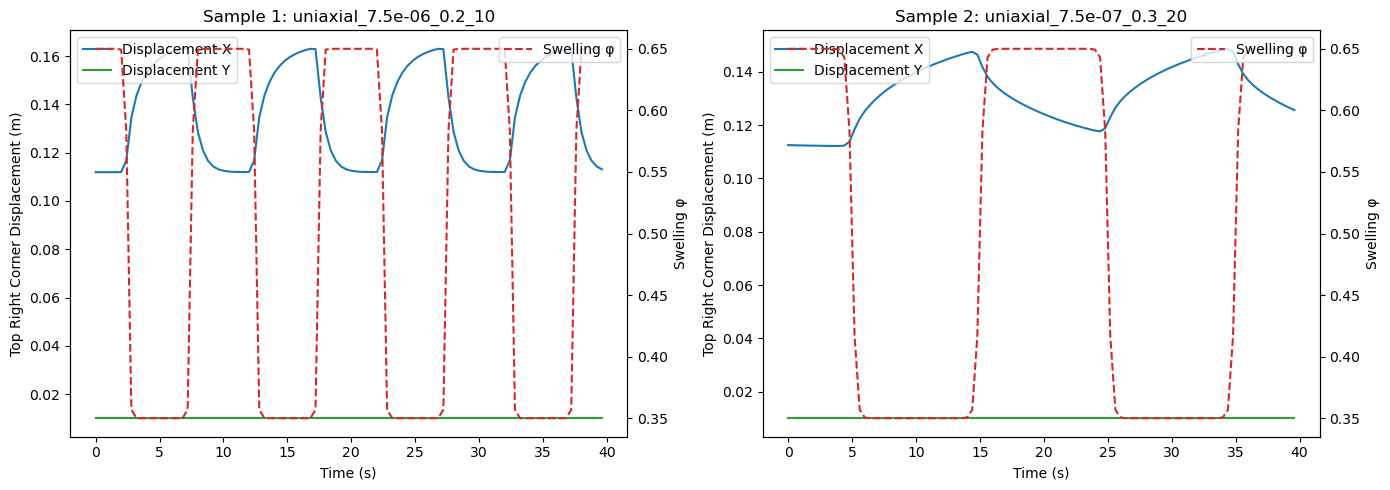

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_corner_response(sample, mesh_pos, deformed_pos, ax, timestart=0, timestop = -1, title=""):
    # Extract top-right corner displacement
    step_start = int(timestart/sample.time.max() * sample.time.shape[0])  # Corresponds to time = 2.5s
    step_stop = int(timestop/sample.time.max() * sample.time.shape[0])
    mask = (mesh_pos[:, 0] == np.max(mesh_pos[:, 0])) & (mesh_pos[:, 1] == np.max(mesh_pos[:, 1]))
    top_right_corner_u = deformed_pos[step_start:step_stop, mask, :].squeeze(axis=1)  # (nt, 2)

    # Left y-axis: displacement
    ax.plot(sample["time"][step_start:step_stop], top_right_corner_u[:, 0],
            label="Displacement X", color="tab:blue")
    ax.plot(sample["time"][step_start:step_stop], top_right_corner_u[:, 1],
            label="Displacement Y", color="tab:green")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Top Right Corner Displacement (m)")
    ax.legend(loc="upper left")

    # Right y-axis: swelling φ
    ax2 = ax.twinx()
    ax2.plot(sample["time"][step_start:step_stop], np.max(sample['swelling_phi'].detach().numpy(), axis = 1)[step_start:step_stop],
             label="Swelling φ", color="tab:red", linestyle="--")
    ax2.set_ylabel("Swelling φ")
    ax2.legend(loc="upper right")

    ax.set_title(title)


# Example: two samples (sample1 and sample2 with their deformed_pos arrays)
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)
idx1 = 0
idx2 = 13
sample1 = dataset[idx1]
sample2 = dataset[idx2]
mesh_pos1 = sample1.mesh_pos.numpy()
deformed_pos1 = sample1.world_pos.numpy()
mesh_pos2 = sample2.mesh_pos.numpy()
deformed_pos2 = sample2.world_pos.numpy()
timestop = 40
plot_corner_response(sample1, mesh_pos1, deformed_pos1, axes[0],
                     timestart=0, timestop = timestop, title=f"Sample 1: {dataset.get_name(idx1)}")
plot_corner_response(sample2, mesh_pos2, deformed_pos2, axes[1],
                     timestart=0, timestop = timestop, title=f"Sample 2: {dataset.get_name(idx2)}")

plt.tight_layout()
plt.show()


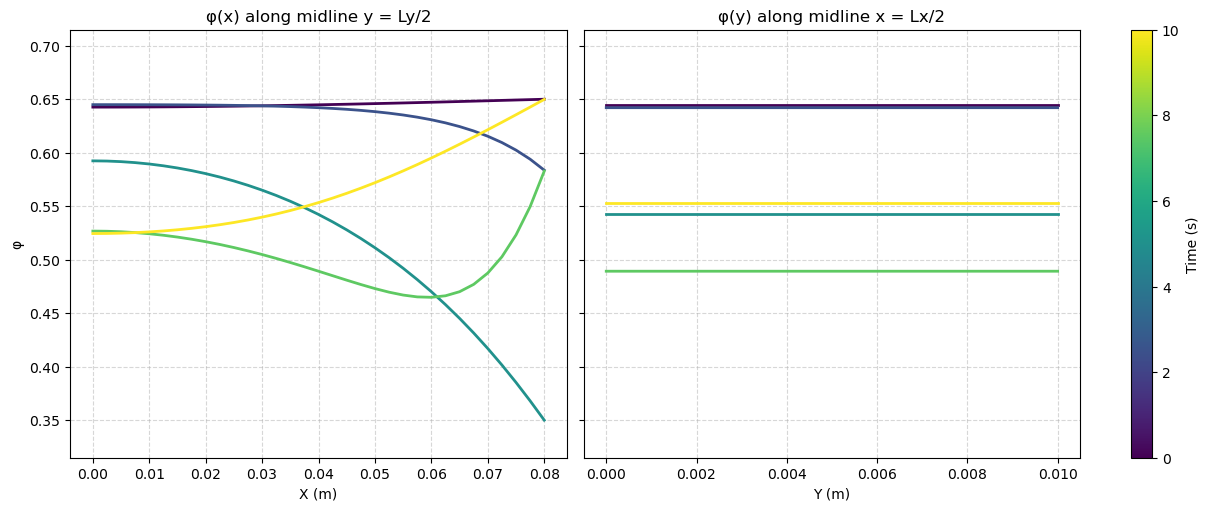

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# pick sample
sample = dataset[idx]
mesh_pos = sample.mesh_pos.numpy()          # (num_nodes, 2)
phi = sample.phi.numpy()        # (num_timesteps, num_nodes)
time_series = sample.time.numpy()      # (num_timesteps,)

# domain size (assuming rectangular domain)
Ly = np.max(mesh_pos[:, 1]) - np.min(mesh_pos[:, 1])
Lx = np.max(mesh_pos[:, 0]) - np.min(mesh_pos[:, 0])

# --- horizontal midline: y = Ly/2 ---
y_mid = np.min(mesh_pos[:, 1]) + Ly/2
tol = Lx * 1e-3
mid_nodes_x = np.where(np.abs(mesh_pos[:, 1] - y_mid) < tol)[0]
x_mid_coords = mesh_pos[mid_nodes_x, 0]
phi_mid_x = phi[:, mid_nodes_x]

# --- vertical midline: x = Lx/2 ---
x_mid = np.min(mesh_pos[:, 0]) + Lx/2
tol = Ly * 1e-2
mid_nodes_y = np.where(np.abs(mesh_pos[:, 0] - x_mid) < tol)[0]
y_mid_coords = mesh_pos[mid_nodes_y, 1]
phi_mid_y = phi[:, mid_nodes_y]

# --- plotting setup ---
plot_times = np.linspace(0, 10, 5)
norm = plt.Normalize(vmin=plot_times[0], vmax=plot_times[-1])
cmap = plt.cm.viridis

# use constrained_layout to handle spacing
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True, constrained_layout=True)

# φ(x) along y = Ly/2
for t in plot_times:
    timestep = np.argmin(np.abs(time_series - t))
    color = cmap(norm(t))
    axes[0].plot(x_mid_coords, phi_mid_x[timestep], color=color, lw=2)

axes[0].set_xlabel("X (m)")
axes[0].set_ylabel("φ")
axes[0].set_ylim(0.35 * 0.9, 0.65 * 1.1)
axes[0].set_title("φ(x) along midline y = Ly/2")
axes[0].grid(True, linestyle="--", alpha=0.5)

# φ(y) along x = Lx/2
for t in plot_times:
    timestep = np.argmin(np.abs(time_series - t))
    color = cmap(norm(t))
    axes[1].plot(y_mid_coords, phi_mid_y[timestep], color=color, lw=2)

axes[1].set_xlabel("Y (m)")
axes[1].set_title("φ(y) along midline x = Lx/2")
axes[1].grid(True, linestyle="--", alpha=0.5)

# shared colorbar outside
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation="vertical", label="Time (s)", location="right")

plt.show()


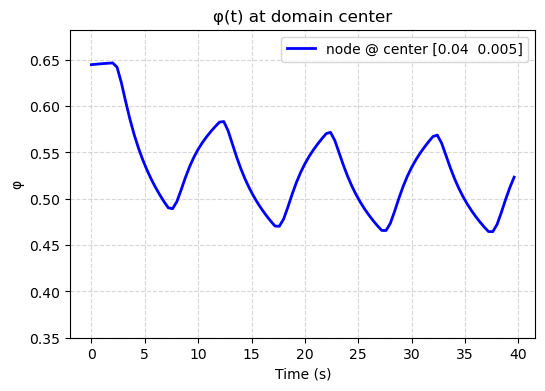

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# pick sample
sample = dataset[idx]
mesh_pos = sample.mesh_pos.numpy()          # (num_nodes, 2)
phi = sample.phi.numpy()        # (num_timesteps, num_nodes)
time = sample.time.numpy()             # (num_timesteps,)

# --- find node closest to domain center ---
Lx = np.max(mesh_pos[:, 0]) - np.min(mesh_pos[:, 0])
Ly = np.max(mesh_pos[:, 1]) - np.min(mesh_pos[:, 1])
center = np.array([np.min(mesh_pos[:, 0]) + Lx/2,
                   np.min(mesh_pos[:, 1]) + Ly/2])

# distance of each node from center
dist = np.linalg.norm(mesh_pos - center, axis=1)
center_node = np.argmin(dist)

# --- extract φ(t) at that node ---
phi_center = phi[:, center_node]   # (num_timesteps,)

# --- plot φ vs time ---
plt.figure(figsize=(6,4))
plt.plot(time, phi_center, c="b", lw=2, label=f"node @ center {center}")
plt.xlabel("Time (s)")
plt.ylabel("φ")
plt.ylim(0.35, 0.65 * 1.05)
plt.title("φ(t) at domain center")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()


In [9]:
deformed_pos

array([[[-7.12605370e-20, -1.32984800e-26],
        [ 3.52697074e-03, -1.70011481e-26],
        [ 7.05387117e-03, -8.76344039e-27],
        ...,
        [ 1.05529360e-01,  9.99999978e-03],
        [ 1.09029755e-01,  9.99999978e-03],
        [ 1.12528756e-01,  9.99999978e-03]],

       [[-7.10898793e-20, -1.21527320e-26],
        [ 3.52451159e-03, -1.55362011e-26],
        [ 7.04895891e-03, -8.00961677e-27],
        ...,
        [ 1.05479650e-01,  9.99999978e-03],
        [ 1.08979866e-01,  9.99999978e-03],
        [ 1.12478793e-01,  9.99999978e-03]],

       [[-7.09336650e-20, -1.11049359e-26],
        [ 3.52226011e-03, -1.41965288e-26],
        [ 7.04446202e-03, -7.32002523e-27],
        ...,
        [ 1.05434127e-01,  9.99999978e-03],
        [ 1.08934179e-01,  9.99999978e-03],
        [ 1.12433054e-01,  9.99999978e-03]],

       ...,

       [[-1.21369122e-19,  9.03929904e-27],
        [ 4.24911734e-03,  1.34026513e-26],
        [ 8.49837810e-03, -1.42279631e-26],
        ...,
     

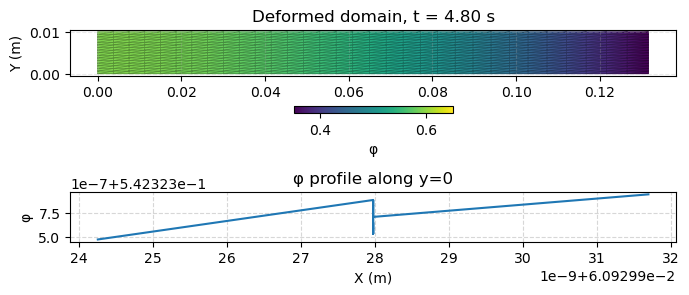

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

# Pick a timestep
time = 5
timestep = np.argmin(np.abs(sample.time.numpy() - time))  # robust timestep selection

# Extract fields at timestep
mesh_pos = sample.mesh_pos.numpy()
cells = sample.cells.numpy()
phi = sample.phi[timestep, :, 0].numpy()  # scalar field
deformed_pos = sample.world_pos[timestep, :].numpy()

# Triangulation with deformed positions
triang_def = tri.Triangulation(deformed_pos[:, 0], deformed_pos[:, 1], cells)

# --- Figure with subplots (vertical stack) ---
fig, axes = plt.subplots(
    2, 1, figsize=(7, 4),  # smaller overall height too
    gridspec_kw={'height_ratios': [4, 1]}  # top 4x taller than bottom
)

# --- Top: deformed domain with φ field ---
tpc = axes[0].tripcolor(triang_def, phi, shading="gouraud",
                        cmap="viridis", vmin=0.35, vmax=0.65)
axes[0].triplot(triang_def, color="k", lw=0.5, alpha=0.3)
axes[0].set_aspect("equal")
axes[0].set_title(f"Deformed domain, t = {sample.time[timestep]:.2f} s")
# axes[0].set_xlabel("X (m)")
axes[0].set_ylabel("Y (m)")
axes[0].grid(visible=True, linestyle='--', alpha=0.25)

# Colorbar under top plot
cbar = fig.colorbar(tpc, ax=axes[0], orientation='horizontal',
                    pad=0.15, fraction=0.04, shrink=0.5)
cbar.set_label("φ")

# --- Bottom: φ profile along y=0 ---
tol = 1e-3  # tolerance to select nodes close to y=0
mid_nodes = np.where(np.abs(mesh_pos[:, 0] - 0.08/2) < tol)[0]

x_profile = deformed_pos[mid_nodes, 0]
phi_profile = phi[mid_nodes]

# Sort by x for clean line
sort_idx = np.argsort(x_profile)
x_profile = x_profile[sort_idx]
phi_profile = phi_profile[sort_idx]

axes[1].plot(x_profile, phi_profile, label=f"t = {sample.time[timestep]:.2f} s")
axes[1].set_xlabel("X (m)")
axes[1].set_ylabel("φ")
# axes[1].set_ylim(0.35, 0.65 * 1.1)
axes[1].set_title("φ profile along y=0")
axes[1].grid(True, linestyle="--", alpha=0.5)
# axes[1].legend()

plt.tight_layout()
plt.show()


In [11]:
sample.world_pos.shape[0]

100

In [12]:
sample.swelling_phi.max()

tensor(0.6500)

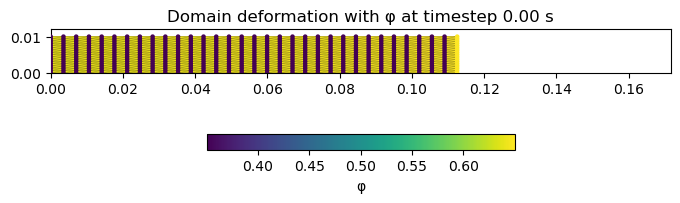

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np

# Mesh info
mesh_pos = sample.mesh_pos.numpy()
cells = sample.cells.numpy()
nt = range(0, sample.world_pos.shape[0], 1)   # all timesteps

# Global phi min/max across all timesteps
phi_all = sample.phi.numpy()
phi_min, phi_max = phi_all.min(), phi_all.max()

# Figure setup
fig, ax = plt.subplots(figsize=(8,4))
ax.set_aspect("equal")

# First frame data
phi0 = sample.phi[0].squeeze(-1).numpy()
deformed_pos0 = sample.world_pos[0].numpy()

# Create triangulation
triang_def = tri.Triangulation(deformed_pos0[:, 0], deformed_pos0[:, 1], cells)

# Tripcolor (this is updated in place)
tpc = ax.tripcolor(triang_def, phi0, shading="gouraud", cmap="viridis",
                   vmin=phi_min, vmax=phi_max)

# Colorbar
cbar = plt.colorbar(
    tpc, ax=ax, label="φ",
    orientation='horizontal',
    pad=0.2,
    fraction=0.05,
    shrink=0.7
)

# Initial wireframe (store returned lines)
wire = ax.triplot(triang_def, color="k", lw=0.5, alpha=0.3)

# Fix axis limits once
# swell_phi = sample.swelling_phi.numpy()
# # Initial scatter plot for special nodes
# swell_node_scatter = ax.scatter(
#     deformed_pos0[:, 0], 
#     deformed_pos0[:, 1],
#     c=swell_phi[0], s=5, zorder=3
# )

max_world_pos_x = sample.world_pos[:, :, 0].max()
max_world_pos_y = sample.world_pos[:, :, 1].max()
min_world_pos_x = sample.world_pos[:, :, 0].min()
min_world_pos_y = sample.world_pos[:, :, 1].min()
ax.set_xlim(min_world_pos_x, max_world_pos_x * 1.2)
ax.set_ylim(min_world_pos_y, max_world_pos_y * 1.2)
# --- Update function ---
prev_wire = []
def update(frame):
    global prev_wire
    phi = sample.phi[frame].squeeze(-1).numpy()
    swell_phi = sample.swelling_phi[frame].squeeze(-1).numpy()
    deformed_pos = sample.world_pos[frame].numpy()

    # Update node positions
    triang_def.x = deformed_pos[:, 0]
    triang_def.y = deformed_pos[:, 1]

    # Update φ values
    tpc.set_array(phi)

    # Update wireframe data
    for line in prev_wire:
        line.remove()
    wire.set_offsets(deformed_pos)
    swell_node_scatter.set_array(swell_phi)
    # Draw new wireframe
    prev_wire = ax.triplot(triang_def, color='k', lw=0.5, alpha=0.3)
    ax.set_title(f"Domain deformation with φ at timestep {sample.time[frame]:.2f} s")
    return [tpc, swell_node_scatter] + prev_wire

# Animate
anim = FuncAnimation(fig, update, frames=nt, interval=200, blit=False)

# Save GIF
data_name = dataset.get_name(idx)
anim.save(f"hydrogel_{data_name}.gif", writer=PillowWriter(fps=20))


In [109]:
data_name = dataset.get_name(idx)

In [110]:
data_name

'bending_7.5e-07_0.2_1.0_0.65_0.35_10'

In [1]:
import numpy as np

In [2]:
data = np.load("/mnt/c/Users/narun/Desktop/Project/hydrogel/gnn/rollouts/uniaxial_testset/uniaxial_7e-08_0.35_staircase_swell_{'t0': 60, 'steps': [0.45, 0.35, 0.45, 0.65], 'step_duration': 5}/rollout.npz")

In [3]:
mesh_pos = data["mesh_pos"]
pred_world_pos = data['pred'][:, :, :2]
gt_world_pos = data['gt'][:, :, :2]
pred_phi = data['pred'][:, :, 2:]
gt_phi = data['gt'][:, :, 2:]
cells = data["cells"]
node_type = data["node_type"]

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_deformed_domain(data, timestep=0):
    """
    Plots a deformed domain with 3 subplots using triangular contour plots:
    1. Predicted world positions (phi)
    2. Ground truth world positions (phi)
    3. Error of phi (absolute difference)
    
    Args:
        data (dict): Dictionary containing keys "mesh_pos", "pred", "gt", "cells"
        timestep (int): Which timestep to visualize
    """
    
    mesh_pos = data["mesh_pos"]
    pred_world_pos = data['pred'][timestep, :, :2]
    gt_world_pos = data['gt'][timestep, :, :2]
    pred_phi = data['pred'][timestep, :, 2:].squeeze(-1)
    gt_phi = data['gt'][timestep, :, 2:].squeeze(-1)
    phi_error = np.abs(pred_phi - gt_phi)
    cells = data["cells"]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Predicted phi
    tcf0 = axes[0].tricontourf(pred_world_pos[:, 0], pred_world_pos[:, 1], cells, pred_phi, cmap='viridis')
    axes[0].triplot(pred_world_pos[:, 0], pred_world_pos[:, 1], cells, color='lightgray', alpha=0.5)
    axes[0].set_title("Predicted Phi")
    axes[0].axis('equal')
    fig.colorbar(tcf0, ax=axes[0])
    
    # Ground truth phi
    tcf1 = axes[1].tricontourf(gt_world_pos[:, 0], gt_world_pos[:, 1], cells, gt_phi, cmap='viridis')
    axes[1].triplot(gt_world_pos[:, 0], gt_world_pos[:, 1], cells, color='lightgray', alpha=0.5)
    axes[1].set_title("Ground Truth Phi")
    axes[1].axis('equal')
    fig.colorbar(tcf1, ax=axes[1])
    
    # Phi error
    tcf2 = axes[2].tricontourf(gt_world_pos[:, 0], gt_world_pos[:, 1], cells, phi_error, cmap='viridis')
    axes[2].triplot(gt_world_pos[:, 0], gt_world_pos[:, 1], cells, color='lightgray', alpha=0.5)
    axes[2].set_title("Phi Error (|GT - Pred|)")
    axes[2].axis('equal')
    fig.colorbar(tcf2, ax=axes[2])
    
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_deformed_domain_tricolor(data, timestep=0)


In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_deformed_domain_overlay(data, timestep=0):
    """
    Plots predicted phi as a colored mesh with the ground truth mesh overlaid as a wireframe.

    Args:
        data (dict): Dictionary containing keys "mesh_pos", "pred", "gt", "cells"
        timestep (int): Which timestep to visualize
    """
    # Extract data
    pred_world_pos = data['pred'][timestep, :, :2]
    gt_world_pos = data['gt'][timestep, :, :2]
    pred_phi = data['pred'][timestep, :, 2:].squeeze(-1)
    cells = data["cells"]

    # Create plot
    fig, ax = plt.subplots(figsize=(8, 6))

    # Predicted phi as colored mesh
    tcf = ax.tricontourf(pred_world_pos[:, 0], pred_world_pos[:, 1], cells, pred_phi, cmap='viridis')
    fig.colorbar(tcf, ax=ax, label='Phi')

    # Predicted mesh edges (optional, subtle)
    ax.triplot(pred_world_pos[:, 0], pred_world_pos[:, 1], cells, color='lightgray', alpha=0.3)

    # Ground truth mesh as wireframe
    ax.triplot(gt_world_pos[:, 0], gt_world_pos[:, 1], cells, color='red', alpha=0.4, label='GT Mesh')

    ax.set_title("Predicted Phi with Ground Truth Wireframe")
    ax.axis('equal')
    ax.legend()
    plt.show()


1


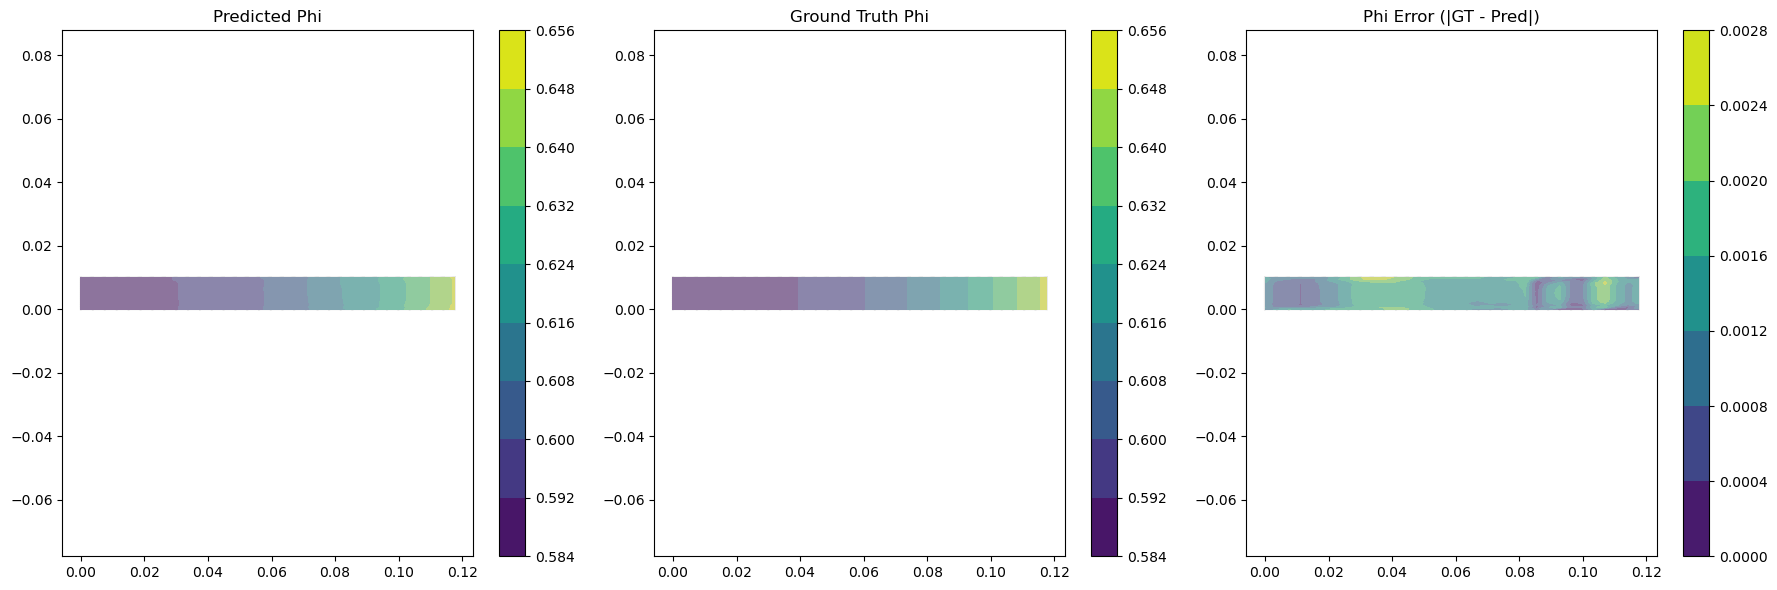

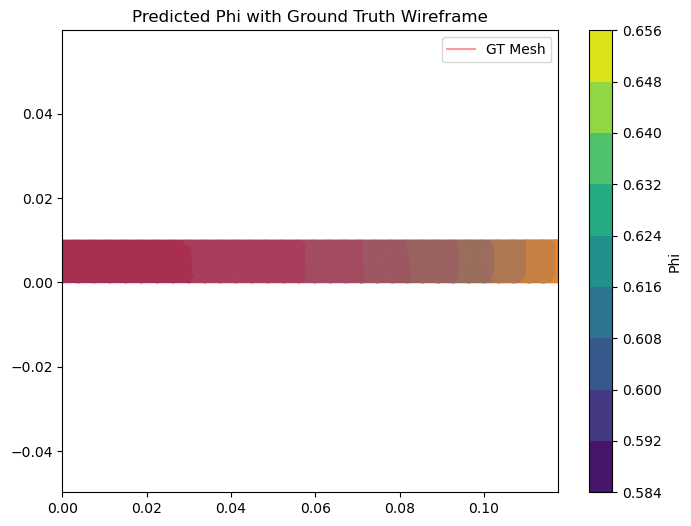

In [6]:
time = 0.25
timestep = np.argmin(np.abs(data["time"] - time))  # robust timestep selection
print(timestep)
plot_deformed_domain(data, timestep)
plot_deformed_domain_overlay(data, timestep)

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation, PillowWriter

def create_deformed_domain_gif(data, filename="deformed_domain.gif"):
    """
    Creates an animated GIF of the deformed domain over all timesteps.
    
    Args:
        data (dict): Dictionary containing keys "mesh_pos", "pred", "gt", "cells"
        filename (str): Output GIF filename
    """
    mesh_pos = data["mesh_pos"]
    cells = data["cells"]
    n_timesteps = data['pred'].shape[0]

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # # Initialize empty tricontours
    # tcf0 = axes[0].tricontourf([], [], [], [], cmap='viridis')
    # tcf1 = axes[1].tricontourf([], [], [], [], cmap='viridis')
    # tcf2 = axes[2].tricontourf([], [], [], [], cmap='hot')

    # Setup axes
    for ax, title in zip(axes, ["Predicted Phi", "Ground Truth Phi", "Phi Error (|GT - Pred|)"]):
        ax.set_aspect('equal')
        ax.set_title(title)

    # Function to update each frame
    def update(timestep):
        axes[0].cla()
        axes[1].cla()
        axes[2].cla()

        pred_world_pos = data['pred'][timestep, :, :2]
        gt_world_pos = data['gt'][timestep, :, :2]
        pred_phi = data['pred'][timestep, :, 2:].squeeze(-1)
        gt_phi = data['gt'][timestep, :, 2:].squeeze(-1)
        phi_error = np.abs(pred_phi - gt_phi)

        # Predicted
        tcf0 = axes[0].tricontourf(pred_world_pos[:, 0], pred_world_pos[:, 1], cells, pred_phi, cmap='viridis')
        axes[0].triplot(pred_world_pos[:, 0], pred_world_pos[:, 1], cells, color='lightgray', alpha=0.5)
        axes[0].set_title("Predicted Phi")
        axes[0].axis('equal')

        # Ground truth
        tcf1 = axes[1].tricontourf(gt_world_pos[:, 0], gt_world_pos[:, 1], cells, gt_phi, cmap='viridis')
        axes[1].triplot(gt_world_pos[:, 0], gt_world_pos[:, 1], cells, color='lightgray', alpha=0.5)
        axes[1].set_title("Ground Truth Phi")
        axes[1].axis('equal')

        # Error
        tcf2 = axes[2].tricontourf(gt_world_pos[:, 0], gt_world_pos[:, 1], cells, phi_error, cmap='hot')
        axes[2].triplot(gt_world_pos[:, 0], gt_world_pos[:, 1], cells, color='lightgray', alpha=0.5)
        axes[2].set_title("Phi Error (|GT - Pred|)")
        axes[2].axis('equal')

        return tcf0, tcf1, tcf2

    anim = FuncAnimation(fig, update, frames=n_timesteps, blit=False)
    writer = PillowWriter(fps=20)  # Adjust FPS as needed
    anim.save(filename, writer=writer)
    plt.close(fig)
    print(f"Saved animation to {filename}")

# Example usage:
create_deformed_domain_gif(data, filename="deformed_domain.gif")


Saved animation to deformed_domain.gif


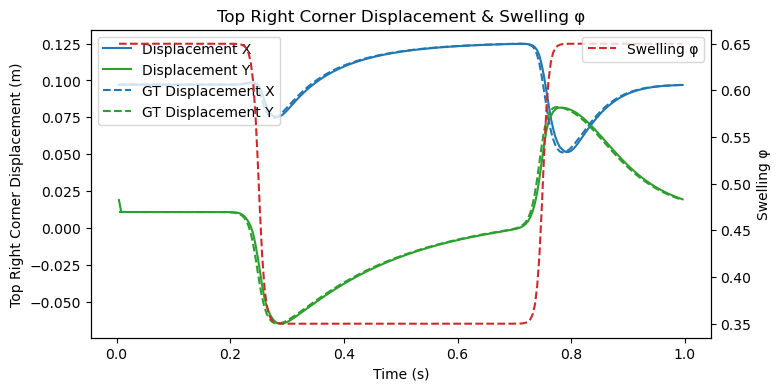

In [336]:
import matplotlib.pyplot as plt
import numpy as np

# Extract top-right corner displacement
timestart = 0  # Corresponds to time = 2.5s
mask = (mesh_pos[:, 0] == np.max(mesh_pos[:, 0])) & (mesh_pos[:, 1] == np.max(mesh_pos[:, 1]))
top_right_corner_u = pred_world_pos[timestart:, mask, :]  # shape: (nt, 1, 2)
top_right_corner_u = top_right_corner_u.squeeze(axis=1)  # (nt, 2)
gt_top_right_corner_u = gt_world_pos[timestart:, mask, :]  # shape: (nt, 1, 2)
gt_top_right_corner_u = gt_top_right_corner_u.squeeze(axis=1)  # (nt, 2)

# Plot
fig, ax1 = plt.subplots(figsize=(8,4))

# Left y-axis: displacement
ax1.plot(data["time"][timestart:], top_right_corner_u[:, 0], label="Displacement X", color="tab:blue")
ax1.plot(data["time"][timestart:], top_right_corner_u[:, 1], label="Displacement Y", color="tab:green")
ax1.plot(data["time"][timestart:], gt_top_right_corner_u[:, 0], label="GT Displacement X", color="tab:blue", linestyle="--")
ax1.plot(data["time"][timestart:], gt_top_right_corner_u[:, 1], label="GT Displacement Y", color="tab:green", linestyle="--")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Top Right Corner Displacement (m)")
ax1.legend(loc="upper left")



# Right y-axis: swelling phi
ax2 = ax1.twinx()
ax2.plot(data["time"][timestart:], np.max(data["swell_phi"], axis = 1)[timestart:], label="Swelling φ", color="tab:red", linestyle="--")
ax2.set_ylabel("Swelling φ")
ax2.legend(loc="upper right")

plt.title("Top Right Corner Displacement & Swelling φ")
plt.show()


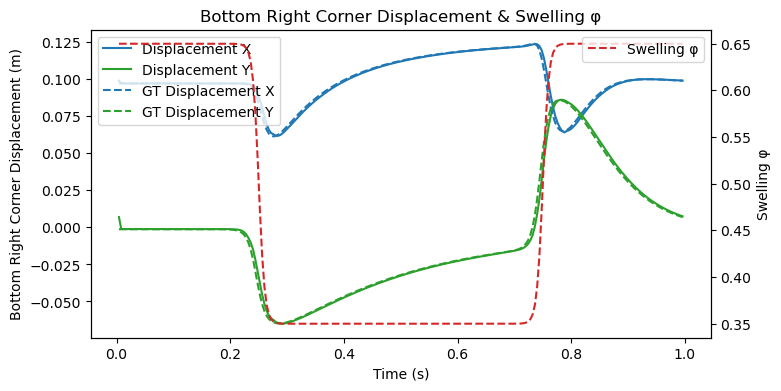

In [337]:
import matplotlib.pyplot as plt
import numpy as np

# Extract bottom-right corner displacement
timestart = 0  # Corresponds to time = 2.5s
mask = (mesh_pos[:, 0] == np.max(mesh_pos[:, 0])) & (mesh_pos[:, 1] == np.min(mesh_pos[:, 1]))
bottom_right_corner_u = pred_world_pos[timestart:, mask, :]  # shape: (nt, 1, 2)
bottom_right_corner_u = bottom_right_corner_u.squeeze(axis=1)  # (nt, 2)
gt_bottom_right_corner_u = gt_world_pos[timestart:, mask, :]  # shape: (nt, 1, 2)
gt_bottom_right_corner_u = gt_bottom_right_corner_u.squeeze(axis=1)  # (nt, 2)

# Plot
fig, ax1 = plt.subplots(figsize=(8,4))

# Left y-axis: displacement
ax1.plot(data["time"][timestart:], bottom_right_corner_u[:, 0], label="Displacement X", color="tab:blue")
ax1.plot(data["time"][timestart:], bottom_right_corner_u[:, 1], label="Displacement Y", color="tab:green")
ax1.plot(data["time"][timestart:], gt_bottom_right_corner_u[:, 0], label="GT Displacement X", color="tab:blue", linestyle="--")
ax1.plot(data["time"][timestart:], gt_bottom_right_corner_u[:, 1], label="GT Displacement Y", color="tab:green", linestyle="--")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Bottom Right Corner Displacement (m)")
ax1.legend(loc="upper left")

# Right y-axis: swelling phi
ax2 = ax1.twinx()
ax2.plot(data["time"][timestart:], np.max(data["swell_phi"], axis=1)[timestart:], label="Swelling φ", color="tab:red", linestyle="--")
# ax2.plot(data["time"][timestart:], np.max(data["swell_phi_rate"], axis=1)[timestart:], label="Swelling Rate φ_dot", color="tab:red", linestyle="--")
ax2.set_ylabel("Swelling φ")
ax2.legend(loc="upper right")

plt.title("Bottom Right Corner Displacement & Swelling φ")
plt.show()


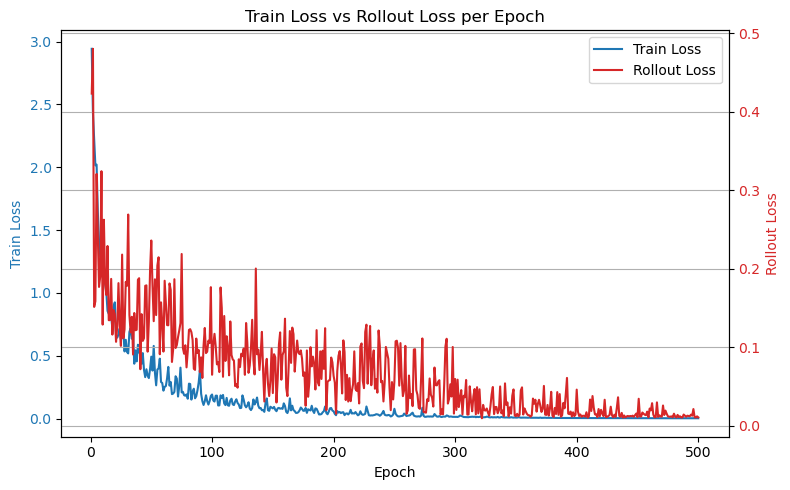

In [352]:
import re
import matplotlib.pyplot as plt

# --- Read log file ---
log_file = "trained_models/20250918T143104/log.txt"
epochs = []
train_loss = []
rollout_loss = []

with open(log_file, 'r') as f:
    for line in f:
        # Match epoch line
        match_epoch = re.search(r'Epoch (\d+), Train Loss: ([\d\.]+)', line)
        if match_epoch:
            epoch = int(match_epoch.group(1))
            tloss = float(match_epoch.group(2))
            epochs.append(epoch)
            train_loss.append(tloss)
        
        # Match rollout loss line
        match_rollout = re.search(r'Rollout Loss: ([\d\.]+)', line)
        if match_rollout:
            rloss = float(match_rollout.group(1))
            rollout_loss.append(rloss)

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(8,5))

# Left y-axis: Train Loss
ax1.plot(epochs, train_loss, color='tab:blue', label='Train Loss')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Train Loss", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Right y-axis: Rollout Loss
ax2 = ax1.twinx()
ax2.plot(epochs, rollout_loss, color='tab:red', label='Rollout Loss')
ax2.set_ylabel("Rollout Loss", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Optional: combined legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title("Train Loss vs Rollout Loss per Epoch")
plt.grid(True)
plt.tight_layout()
plt.show()


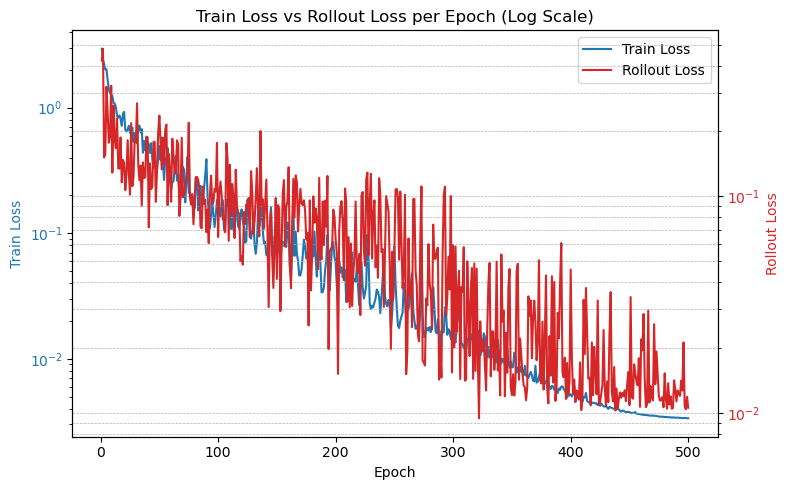

In [353]:
import re
import matplotlib.pyplot as plt

# --- Read log file ---
log_file = "trained_models/20250918T143104/log.txt"
epochs = []
train_loss = []
rollout_loss = []

with open(log_file, 'r') as f:
    for line in f:
        match_epoch = re.search(r'Epoch (\d+), Train Loss: ([\d\.]+)', line)
        if match_epoch:
            epoch = int(match_epoch.group(1))
            tloss = float(match_epoch.group(2))
            epochs.append(epoch)
            train_loss.append(tloss)
        
        match_rollout = re.search(r'Rollout Loss: ([\d\.]+)', line)
        if match_rollout:
            rloss = float(match_rollout.group(1))
            rollout_loss.append(rloss)

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(8,5))

# Left y-axis: Train Loss
ax1.plot(epochs, train_loss, color='tab:blue', label='Train Loss')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Train Loss", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_yscale('log')  # <-- Log scale for Train Loss

# Right y-axis: Rollout Loss
ax2 = ax1.twinx()
ax2.plot(epochs, rollout_loss, color='tab:red', label='Rollout Loss')
ax2.set_ylabel("Rollout Loss", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_yscale('log')  # <-- Log scale for Rollout Loss

# Optional: combined legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title("Train Loss vs Rollout Loss per Epoch (Log Scale)")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()
